#### Code to write
- [x] x dispersion vs. ROIs with legend Attend-bar / Attend-Fix for GazeLeft / GazeCenter / GazeRight (1 line by 3 column plot)
- [x] x dispersion vs. ROIs with legend GazeLeft / GazeCenter / GazeRight for Attend-bar / Attend-Fix (1 line 2 column plot)
- [x] Per ROIs Attend-Bar vs Attend-Fix irrespective of gaze-conditions
- [x] Per ROIs Attend-Bar vs Attend-Fix irrespective of gaze-conditions
- [x] Save all figures

In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.express as px
from plot_utils import plotly_template

# stats
from scipy.stats import permutation_test
def statistic(condA, condB, axis):
    return np.nanmean(condA, axis=axis) - np.nanmean(condB, axis=axis)
n_permutation = 10000

def get_pval(perm_res):
    p_val_unilateral = perm_res.pvalue/2
    p_val_bilateral = perm_res.pvalue

    if p_val_unilateral > 0.05: p_text_unilateral = 'p = {:1.2f}'.format(p_val_unilateral)
    if p_val_unilateral < 0.05: p_text_unilateral = 'p < 0.05'
    if p_val_unilateral < 0.01: p_text_unilateral = 'p < 0.01'
    if p_val_unilateral < 0.001: p_text_unilateral = 'p < 0.001'
    if p_val_unilateral < 0.0001: p_text_unilateral = 'p < 0.0001'

    if p_val_bilateral > 0.05: p_text_bilateral = 'p = {:1.2f}'.format(p_val_bilateral)
    if p_val_bilateral < 0.05: p_text_bilateral = 'p < 0.05'
    if p_val_bilateral < 0.01: p_text_bilateral = 'p < 0.01'
    if p_val_bilateral < 0.001: p_text_bilateral = 'p < 0.001'
    if p_val_bilateral < 0.0001: p_text_bilateral = 'p < 0.0001'
    
    return (p_val_unilateral, p_text_unilateral, p_val_bilateral, p_text_bilateral)
    

# Define parameters
subjects = ['sub-001', 'sub-002', 'sub-003', 'sub-004',
            'sub-005', 'sub-006', 'sub-007', 'sub-008']
subjects_plot = ['sub-001', 'sub-002', 'sub-003', 'sub-004',
                 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'group']
rois = ['V1', 'V2', 'V3', 'V3AB', 'hMT+', 'LO',
        'VO', 'iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS']

# Graph specific plot
gaze_tasks = ['GazeCenter', 'GazeLeft', 'GazeRight']
attend_tasks = ['AttendBar','AttendFix']
attend_tasks_txt = ['Attend-bar', 'Attend-fix']

# Define folders
base_dir = '/home/mszinte/disks/meso_S/data/gaze_prf'
bids_dir = "{}".format(base_dir)
pp_dir = "{}/derivatives/pp_data".format(base_dir)
group_tsv_dir = '{}/{}/decode/tsv'.format(pp_dir, 'group')


# General figure settings
template_specs = dict(  axes_color="rgba(0, 0, 0, 1)",
                        axes_width=2,
                        axes_font_size=13,
                        bg_col="rgba(255, 255, 255, 1)",
                        font='Arial',
                        title_font_size=15,
                        plot_width=1.5)
fig_template = plotly_template(template_specs)

In [63]:
# Figure settings
margin_t, margin_b, margin_l, margin_r = 50, 100, 100 ,50
yaxis_range = [0.3, 12.7]
yaxis_tick = 12
yaxis_tickvals = np.flipud(np.linspace(1,12,yaxis_tick))
yaxis_ticktext = rois

gc_colors = ["rgba(243, 146, 0, 1)", "rgba(242, 190, 121, 1)"]
gl_colors = ["rgba(41, 101, 44, 1)", "rgba(153, 198, 98, 1)"]
gr_colors = ["rgba(142, 19, 84, 1)", "rgba(230, 151, 193, 1)"]

hover = 'ROI: %{y}<br>' + 'Decoded uncertainty: %{x:1.2f}'
y_rois = np.flipud(np.arange(0,len(rois))+1)

xaxis_range = [0, 10]
xaxis_tick = 6
xaxis_tickvals = np.linspace(xaxis_range[0],xaxis_range[1],xaxis_tick)
xaxis_title = 'Decoded uncertainty (dva)'
xaxis_ticktext = []
[xaxis_ticktext.append(('{:g}'.format(val))) for val in xaxis_tickvals];

# x_gap_line = 0.2*xaxis_range[1]
# x_gap_asterisk = 0.25*xaxis_range[1]
# x_gap2_line = 0.25*xaxis_range[1]
# x_gap2_asterisk = 0.3*xaxis_range[1]
# x_gap3_line = 0.3*xaxis_range[1]
# x_gap3_asterisk = 0.35*xaxis_range[1]

x_gap_asterisk = 0.25
x_stats_line = 8;
x_stats2_line = 8.5;
x_stats3_line = 9;

showlegend = False

In [47]:
fist_line = 0
for subject in subjects:
    for gaze_task in gaze_tasks:
        for attend_task, attend_task_txt in zip(attend_tasks, attend_tasks_txt):
            for roi_num, roi in enumerate(rois):
                
                # load files
                run1_fn = "{}/{}/decode/fit/{}_ses-01_task-{}{}_roi-{}_nvoxels-250_resizefactor-3_mcmcbarpars.tsv".format(pp_dir, subject, subject, gaze_task, attend_task, roi)
                run2_fn = "{}/{}/decode/fit/{}_ses-02_task-{}{}_roi-{}_nvoxels-250_resizefactor-3_mcmcbarpars.tsv".format(pp_dir, subject, subject, gaze_task, attend_task, roi)

                run1_df = pd.read_csv(run1_fn,sep="\t")
                run2_df = pd.read_csv(run2_fn,sep="\t")
                
                x_std_run1 = run1_df.groupby(['time']).x.std().mean()
                x_std_run2 = run2_df.groupby(['time']).x.std().mean()
                df_roi = pd.DataFrame({'subject': [subject],
                                       'gaze_task': [gaze_task],
                                       'roi': [roi],
                                       'attend_task': [attend_task],
                                       'decoded_x_std': np.mean((x_std_run1,x_std_run2)),
                                       })
                
                # across subject
                if fist_line == 0:
                    df_group = df_roi
                    fist_line = 1
                else: 
                    df_group = pd.concat([df_group, df_roi])

In [49]:
df_group

,subject,gaze_task,roi,attend_task,decoded_x_std
0,sub-001,GazeCenter,V1,AttendBar,2.589076
0,sub-001,GazeCenter,V2,AttendBar,2.082974
0,sub-001,GazeCenter,V3,AttendBar,1.703871
0,sub-001,GazeCenter,V3AB,AttendBar,2.880360
0,sub-001,GazeCenter,hMT+,AttendBar,5.172390
...,...,...,...,...,...
0,sub-008,GazeRight,iIPS,AttendFix,5.267257
0,sub-008,GazeRight,sIPS,AttendFix,5.297307
0,sub-008,GazeRight,iPCS,AttendFix,4.708274
0,sub-008,GazeRight,sPCS,AttendFix,5.169447


### Attend-bar vs. Attend-fix in different gaze conditions

In [71]:
# Compute permutation statistics results
fist_line = 0
for gaze_task in gaze_tasks:
    for roi_num, roi in enumerate(rois):
        # get values
        ab_decoded_std_array = df_group.loc[(df_group.gaze_task==gaze_task) & 
                                            (df_group.attend_task=='AttendBar') & (df_group.roi==roi)
                                           ].groupby(['subject']).decoded_x_std.mean()

        af_decoded_std_array = df_group.loc[(df_group.gaze_task==gaze_task) & 
                                            (df_group.attend_task=='AttendFix') & (df_group.roi==roi)
                                           ].groupby(['subject']).decoded_x_std.mean()
        
        # comparison ab/af
        ab_af_perm_res = permutation_test((ab_decoded_std_array, af_decoded_std_array), statistic, n_resamples=n_permutation, 
                                     alternative='two-sided', permutation_type='samples', vectorized=True, axis=0)
        ab_af_p_val_uni, ab_af_p_text_uni, ab_af_p_val_bi, ab_af_p_text_bi = get_pval(ab_af_perm_res)
        
        df_stats = pd.DataFrame({  'roi': [roi],
                                   'gaze_task': gaze_task,
                                   'ab_decoded_std_mean': np.nanmean(ab_decoded_std_array),
                                   'ab_decoded_std_sem': np.nanstd(ab_decoded_std_array)/np.sqrt(ab_decoded_std_array.shape[0]-1),  
                                   'af_decoded_std_mean': np.nanmean(af_decoded_std_array),
                                   'af_decoded_std_sem': np.nanstd(af_decoded_std_array)/np.sqrt(af_decoded_std_array.shape[0]-1),
                                   'ab_af_diff': ab_af_perm_res.statistic,
                                   'ab_af_p_val_unilateral': ab_af_p_val_uni,
                                   'ab_af_p_text_unilateral': ab_af_p_text_uni,
                                   'ab_af_p_val_bilateral': ab_af_p_val_bi,
                                   'ab_af_p_text_bilateral': ab_af_p_text_bi})
        
        # across roi
        if fist_line == 0: 
            df_stats_roi = df_stats
            fist_line = 1
        else: 
            df_stats_roi = pd.concat([df_stats_roi, df_stats])

df_stats_roi_fn = "{}/group_decoded_std_stats.tsv".format(group_tsv_dir)
print('saving {}'.format(df_stats_roi_fn))
df_stats_roi.to_csv(df_stats_roi_fn, sep="\t", na_rep='NaN')

saving /home/mszinte/disks/meso_S/data/gaze_prf/derivatives/pp_data/group/decode/tsv/group_decoded_std_stats.tsv


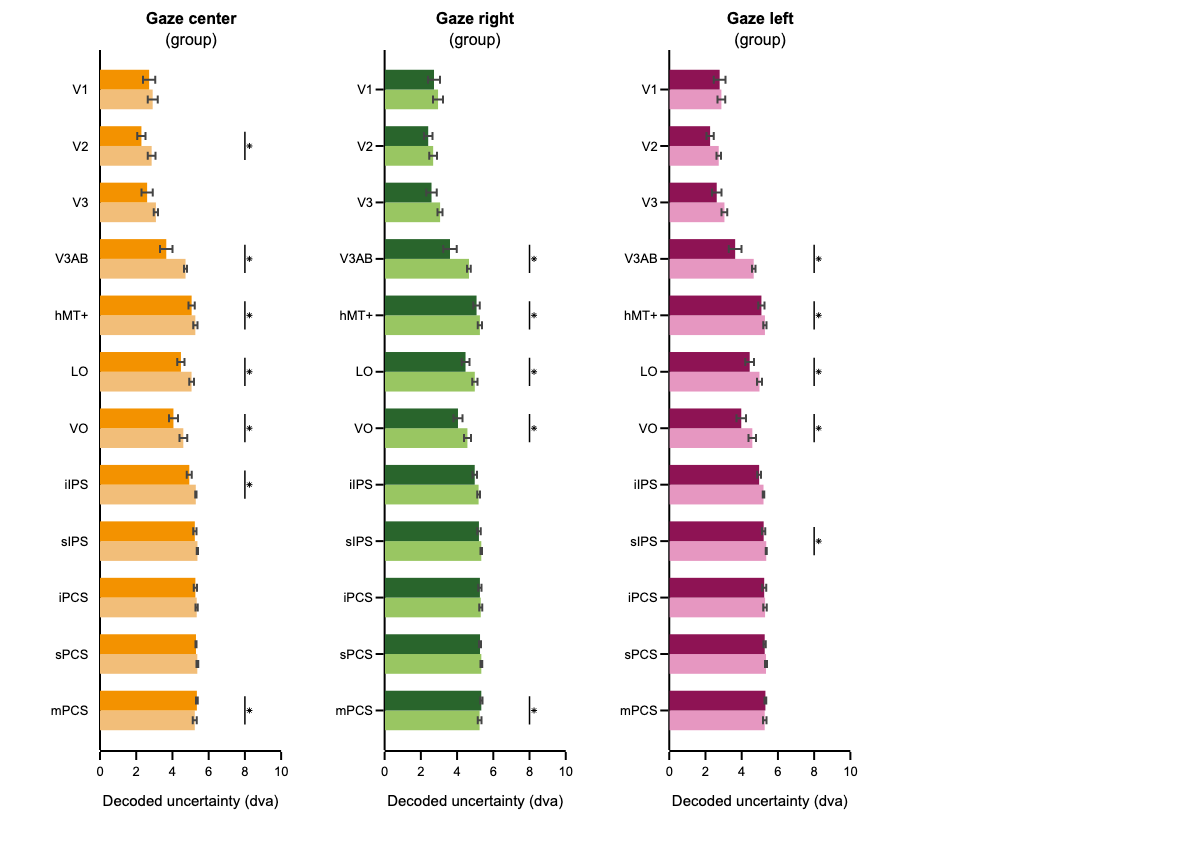

In [72]:
# Subplot settings
rows, cols = 1, 4
row_heights, column_widths =  [1], [1,1,1,1]
sb_specs = [[{},{},{},{}]]
subplot_width, subplot_height = 300,700

fig_width, fig_height = 0, 0
for column_width in column_widths:fig_width += subplot_width*column_width
for row_height in row_heights: fig_height +=subplot_height*row_height
fig_width = fig_width + margin_l + margin_r
fig_height = fig_height + margin_t + margin_b

subplot_titles = ['<b>Gaze center</b><br>(group)'.format(subject),
                  '<b>Gaze right</b><br>(group)'.format(subject),
                  '<b>Gaze left</b><br>(group)'.format(subject)]

fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.04, horizontal_spacing=0.1,
                    column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)

# Draw figure
for gaze_task in gaze_tasks:
    if gaze_task == 'GazeCenter': 
        marker_colors, col = gc_colors, 1
    elif gaze_task == 'GazeLeft': 
        marker_colors, col = gl_colors, 2 
    elif gaze_task == 'GazeRight': 
        marker_colors, col = gr_colors, 3

    # get data
    df_stats.roi = pd.Categorical(df_stats.roi,categories=rois)
    x_af = df_stats_roi.loc[df_stats_roi.gaze_task==gaze_task].af_decoded_std_mean
    x_af_eb = df_stats_roi.loc[df_stats_roi.gaze_task==gaze_task].af_decoded_std_sem
    
    x_ab = df_stats_roi.loc[df_stats_roi.gaze_task==gaze_task].ab_decoded_std_mean
    x_ab_eb = df_stats_roi.loc[df_stats_roi.gaze_task==gaze_task].ab_decoded_std_sem
    
    # plot data
    fig.append_trace(go.Bar(y=y_rois, x=x_af, orientation='h', marker_color=marker_colors[1], 
                            hovertemplate=hover, showlegend=showlegend, 
                            legendgroup='attend-fix', name='<i>attend-fix<i>', 
                            error_x_type='data', error_x_symmetric=False, 
                            error_x_array=x_af_eb, error_x_arrayminus=x_af_eb),
                     row=1, col=col)
    
    fig.append_trace(go.Bar(y=y_rois, x=x_ab, orientation='h', marker_color=marker_colors[0], 
                            hovertemplate=hover, showlegend=showlegend, 
                            legendgroup='attend-bar', name='<i>attend-bar<i>',
                            error_x_type='data', error_x_symmetric=False, 
                            error_x_array=x_ab_eb, error_x_arrayminus=x_ab_eb),
                     row=1, col=col)
    
    # plot stats
#     p_flag = np.array(df_stats_roi.loc[df_stats_roi.gaze_task==gaze_task].ab_af_p_val_bilateral<0.05)
#     fig.append_trace(go.Scatter(x=np.max((x_af,x_ab),axis=0)[p_flag]+x_gap_line, y=y_rois[p_flag], marker_symbol='line-ns-open', 
#                                 showlegend=False, mode='markers', marker_color='black', hoverinfo='skip', marker_size= 15),row=1, col=col)

#     fig.append_trace(go.Scatter(x=np.max((x_af,x_ab),axis=0)[p_flag]+x_gap_asterisk, y=y_rois[p_flag], marker_symbol='asterisk-open',
#                                 showlegend=False, mode='markers', marker_color='black', hoverinfo='skip', marker_size= 10),row=1, col=col)

    
    p_flags = np.array(df_stats_roi.loc[df_stats_roi.gaze_task==gaze_task].ab_af_p_val_bilateral<0.05)
    for t, p_flag in enumerate(p_flags):
        if p_flag:
            y_line = np.linspace(y_rois[t]+0.25,y_rois[t]-0.25,10)
            x_line = y_line*0+x_stats_line
            fig.append_trace(go.Scatter(x=x_line,y=y_line, marker_symbol='line-ns-open', showlegend=False, line_width = 1.5,
                                        mode='lines', marker_color='black', hoverinfo='skip'),row=1, col=col)
            
            fig.append_trace(go.Scatter(x=x_line+x_gap_asterisk,
                                        y=[np.mean(y_line)], marker_symbol='asterisk-open', showlegend=False, 
                                        mode='markers', marker_color='black', hoverinfo='skip', marker_size=5),row=1, col=col)
    
    
    
# set figure axis
for xaxis in ['xaxis', 'xaxis2', 'xaxis3', 'xaxis4']:
    exec("fig.layout.update({}_range=xaxis_range)".format(xaxis))
    exec("fig.layout.update({}_title=xaxis_title)".format(xaxis))
    exec("fig.layout.update({}_tickvals=xaxis_tickvals)".format(xaxis))
    exec("fig.layout.update({}_ticktext=xaxis_ticktext)".format(xaxis))
    exec("fig.layout.update({}_zeroline=True)".format(xaxis))

for yaxis in ['yaxis', 'yaxis2', 'yaxis3', 'yaxis4']:
    exec("fig.layout.update({}_range=yaxis_range)".format(yaxis))
    exec("fig.layout.update({}_tickvals=yaxis_tickvals)".format(yaxis))
    exec("fig.layout.update({}_ticktext=yaxis_ticktext)".format(yaxis))

# set axis
for row in np.arange(rows):
    for col in np.arange(cols):
        fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)

# set figure
fig.layout.update(yaxis_title='', yaxis_color = 'rgba(0,0,0,0)', yaxis_tickfont_color='black', bargap=0.3, template=fig_template, width=fig_width, height=fig_height, margin_l=margin_l, margin_r=margin_r, margin_t=margin_t, margin_b=margin_b,
                  legend_yanchor='top', legend_y=-0.15,legend_x=-0.05, legend_xanchor='left', legend_bgcolor='rgba(255,255,255,0)', legend_tracegroupgap=1)

# show and save figure
fig.show(config={"displayModeBar": False})
fig.write_image("{}/{}_decode_std.pdf".format(group_tsv_dir, subject))
fig.write_html("{}/{}_decode_std.html".format(group_tsv_dir, subject),config={"displayModeBar": False})

### Gaze center vs. Gaze left vs. Gaze right in different attention conditions

In [67]:
# Compute permutation statistics results
fist_line = 0
for attend_task in attend_tasks:
    for roi_num, roi in enumerate(rois):
        # get values
        gc_decoded_std_array = df_group.loc[(df_group.gaze_task=='GazeCenter') & 
                                            (df_group.attend_task==attend_task) & (df_group.roi==roi)
                                           ].groupby(['subject']).decoded_x_std.mean()
        
        gl_decoded_std_array = df_group.loc[(df_group.gaze_task=='GazeLeft') & 
                                            (df_group.attend_task==attend_task) & (df_group.roi==roi)
                                           ].groupby(['subject']).decoded_x_std.mean()
        
        gr_decoded_std_array = df_group.loc[(df_group.gaze_task=='GazeRight') & 
                                            (df_group.attend_task==attend_task) & (df_group.roi==roi)
                                           ].groupby(['subject']).decoded_x_std.mean()
        
        # comparison ab/af
        gc_gl_perm_res = permutation_test((gc_decoded_std_array, gl_decoded_std_array), statistic, n_resamples=n_permutation, 
                                     alternative='two-sided', permutation_type='samples', vectorized=True, axis=0)
        gc_gl_p_val_uni, gc_gl_p_text_uni, gc_gl_p_val_bi, gc_gl_p_text_bi = get_pval(gc_gl_perm_res)
        
        gc_gr_perm_res = permutation_test((gc_decoded_std_array, gr_decoded_std_array), statistic, n_resamples=n_permutation, 
                                     alternative='two-sided', permutation_type='samples', vectorized=True, axis=0)
        gc_gr_p_val_uni, gc_gr_p_text_uni, gc_gr_p_val_bi, gc_gr_p_text_bi = get_pval(gc_gr_perm_res)
        
        gl_gr_perm_res = permutation_test((gl_decoded_std_array, gr_decoded_std_array), statistic, n_resamples=n_permutation, 
                                     alternative='two-sided', permutation_type='samples', vectorized=True, axis=0)
        gl_gr_p_val_uni, gl_gr_p_text_uni, gl_gr_p_val_bi, gl_gr_p_text_bi = get_pval(gl_gr_perm_res)
        
        df_stats = pd.DataFrame({'roi': [roi],
                                 'attend_task': attend_task,
                                 'gc_decoded_std_mean': np.nanmean(gc_decoded_std_array),
                                 'gc_decoded_std_sem': np.nanstd(gc_decoded_std_array)/np.sqrt(gc_decoded_std_array.shape[0]-1),  
                                 'gl_decoded_std_mean': np.nanmean(gl_decoded_std_array),
                                 'gl_decoded_std_sem': np.nanstd(gl_decoded_std_array)/np.sqrt(gl_decoded_std_array.shape[0]-1),
                                 'gr_decoded_std_mean': np.nanmean(gr_decoded_std_array),
                                 'gr_decoded_std_sem': np.nanstd(gr_decoded_std_array)/np.sqrt(gr_decoded_std_array.shape[0]-1),
                                 'gc_gl_diff': gc_gl_perm_res.statistic,
                                 'gc_gl_p_val_unilateral': gc_gl_p_val_uni,
                                 'gc_gl_p_text_unilateral': gc_gl_p_text_uni,
                                 'gc_gl_p_val_bilateral': gc_gl_p_val_bi,
                                 'gc_gl_p_text_bilateral': gc_gl_p_text_bi,
                                 'gc_gr_diff': gc_gr_perm_res.statistic,
                                 'gc_gr_p_val_unilateral': gc_gr_p_val_uni,
                                 'gc_gr_p_text_unilateral': gc_gr_p_text_uni,
                                 'gc_gr_p_val_bilateral': gc_gr_p_val_bi,
                                 'gc_gr_p_text_bilateral': gc_gr_p_text_bi,
                                 'gl_gr_diff': gl_gr_perm_res.statistic,
                                 'gl_gr_p_val_unilateral': gl_gr_p_val_uni,
                                 'gl_gr_p_text_unilateral': gl_gr_p_text_uni,
                                 'gl_gr_p_val_bilateral': gl_gr_p_val_bi,
                                 'gl_gr_p_text_bilateral': gl_gr_p_text_bi,
                                })
        
        # across roi
        if fist_line == 0: 
            df_stats_roi = df_stats
            fist_line = 1
        else: 
            df_stats_roi = pd.concat([df_stats_roi, df_stats])

df_stats_roi_fn = "{}/group_decoded_std_stats2.tsv".format(group_tsv_dir)
print('saving {}'.format(df_stats_roi_fn))
df_stats_roi.to_csv(df_stats_roi_fn, sep="\t", na_rep='NaN')

saving /home/mszinte/disks/meso_S/data/gaze_prf/derivatives/pp_data/group/decode/tsv/group_decoded_std_stats2.tsv


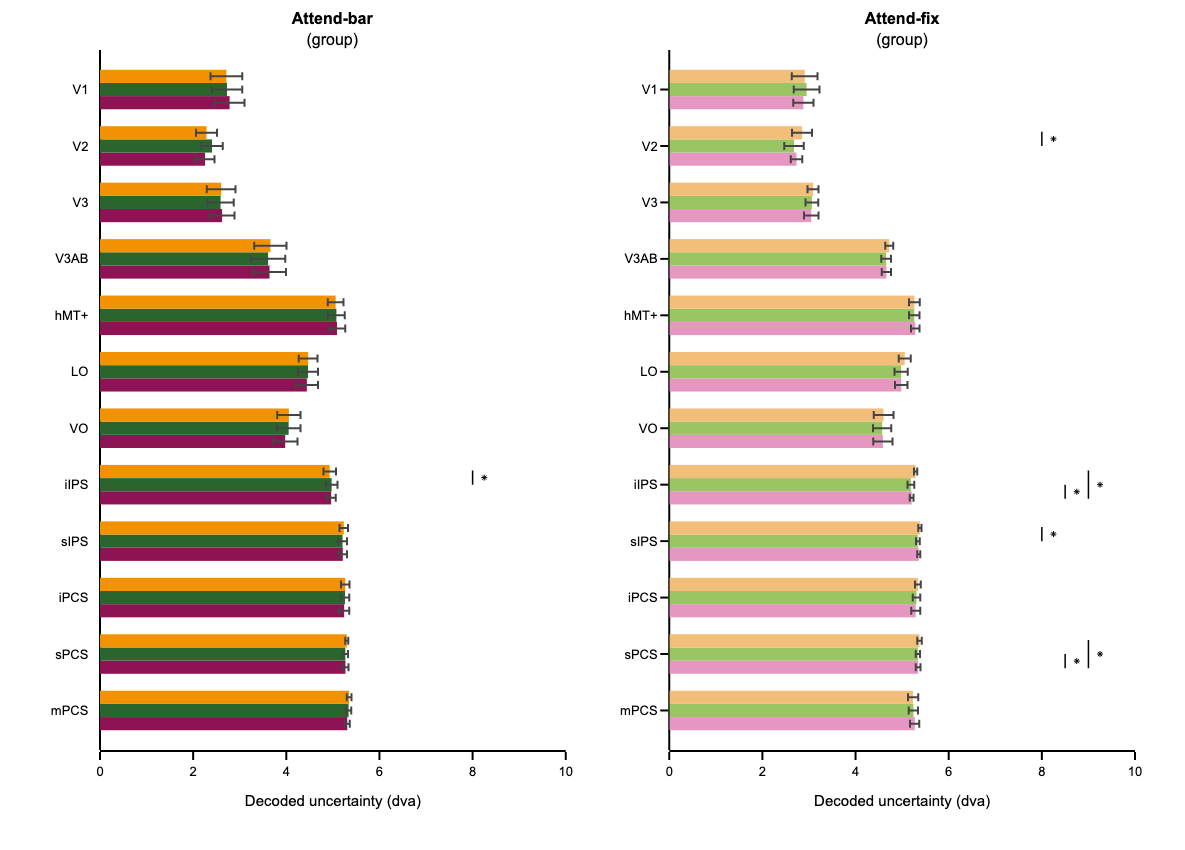

In [69]:
# Subplot settings
rows, cols = 1, 2
row_heights, column_widths =  [1], [1,1]
sb_specs = [[{},{}]]
subplot_width, subplot_height = 300,700

fig_width, fig_height = 0, 0
for column_width in column_widths:fig_width += subplot_width*column_width
for row_height in row_heights: fig_height +=subplot_height*row_height
fig_width = fig_width + margin_l + margin_r
fig_height = fig_height + margin_t + margin_b
subplot_titles = ['<b>Attend-bar</b><br>(group)'.format(subject),
                  '<b>Attend-fix</b><br>(group)'.format(subject)]

fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.04, horizontal_spacing=0.1,
                    column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)

# Draw figure
for attend_task, attend_task_txt in zip(attend_tasks, attend_tasks_txt):
    if attend_task == 'AttendBar': 
        col = 1
        showlegend = False
        marker_colors = [gc_colors[0], gl_colors[0], gr_colors[0]]
    elif attend_task == 'AttendFix': 
        col = 2 
        marker_colors = [gc_colors[1], gl_colors[1], gr_colors[1]]

    # get data    
    df_stats.roi = pd.Categorical(df_stats.roi,categories=rois)
    x_gc = df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gc_decoded_std_mean
    x_gc_eb = df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gc_decoded_std_sem
    x_gl = df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gl_decoded_std_mean
    x_gl_eb = df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gl_decoded_std_sem
    x_gr = df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gr_decoded_std_mean
    x_gr_eb = df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gr_decoded_std_sem

    # plot data
    fig.append_trace(go.Bar(y=y_rois, x=x_gr, orientation='h', marker_color=marker_colors[2], 
                            hovertemplate=hover, showlegend=showlegend, 
                            legendgroup='gaze-right', name='<i>Gaze right<i>',
                            error_x_type='data', error_x_symmetric=False,
                            error_x_array=x_gr_eb, error_x_arrayminus=x_gr_eb),
                     row=1, col=col)
    
    fig.append_trace(go.Bar(y=y_rois, x=x_gl, orientation='h', marker_color=marker_colors[1], 
                            hovertemplate=hover, showlegend=showlegend, 
                            legendgroup='gaze-left', name='<i>Gaze left<i>',
                            error_x_type='data', error_x_symmetric=False,
                            error_x_array=x_gl_eb, error_x_arrayminus=x_gl_eb),
                     row=1, col=col)
    
    fig.append_trace(go.Bar(y=y_rois, x=x_gc, orientation='h', marker_color=marker_colors[0], 
                            hovertemplate=hover, showlegend=showlegend, 
                            legendgroup='gaze-center', name='<i>Gaze center<i>',
                            error_x_type='data', error_x_symmetric=False,
                            error_x_array=x_gc_eb, error_x_arrayminus=x_gc_eb),
                     row=1, col=col)
    
    # plot stats
    p_flags = np.array(df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gc_gl_p_val_bilateral<0.05)
    for t, p_flag in enumerate(p_flags):
        if p_flag:
            y_line = np.linspace(y_rois[t]+0.25,y_rois[t]-0,10)
            x_line = y_line*0+x_stats_line
            fig.append_trace(go.Scatter(x=x_line,y=y_line, marker_symbol='line-ns-open', showlegend=False, line_width = 1.5,
                                        mode='lines', marker_color='black', hoverinfo='skip'),row=1, col=col)
            
            fig.append_trace(go.Scatter(x=x_line+x_gap_asterisk,
                                        y=[np.mean(y_line)], marker_symbol='asterisk-open', showlegend=False, 
                                        mode='markers', marker_color='black', hoverinfo='skip', marker_size=5),row=1, col=col)
            
    p2_flags = np.array(df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gc_gr_p_val_bilateral<0.05)
    for t, p_flag in enumerate(p2_flags):
        if p_flag:
            y_line = np.linspace(y_rois[t]+0.25,y_rois[t]-0.25,10)
            x_line = y_line*0+x_stats3_line
            fig.append_trace(go.Scatter(x=x_line,y=y_line, marker_symbol='line-ns-open', showlegend=False, line_width = 1.5,
                                        mode='lines', marker_color='black', hoverinfo='skip'),row=1, col=col)
            
            fig.append_trace(go.Scatter(x=x_line+x_gap_asterisk,
                                        y=[np.mean(y_line)], marker_symbol='asterisk-open', showlegend=False, 
                                        mode='markers', marker_color='black', hoverinfo='skip', marker_size=5),row=1, col=col)
            
    p3_flags = np.array(df_stats_roi.loc[df_stats_roi.attend_task==attend_task].gl_gr_p_val_bilateral<0.05)
    for t, p_flag in enumerate(p2_flags):
        if p_flag:
            y_line = np.linspace(y_rois[t]+0,y_rois[t]-0.25,10)
            x_line = y_line*0+x_stats2_line
            fig.append_trace(go.Scatter(x=x_line,y=y_line, marker_symbol='line-ns-open', showlegend=False, line_width = 1.5,
                                        mode='lines', marker_color='black', hoverinfo='skip'),row=1, col=col)
            
            fig.append_trace(go.Scatter(x=x_line+x_gap_asterisk,
                                        y=[np.mean(y_line)], marker_symbol='asterisk-open', showlegend=False, 
                                        mode='markers', marker_color='black', hoverinfo='skip', marker_size=5),row=1, col=col)
                
    
# set figure axis
for xaxis in ['xaxis', 'xaxis2']:
    exec("fig.layout.update({}_range=xaxis_range)".format(xaxis))
    exec("fig.layout.update({}_title=xaxis_title)".format(xaxis))
    exec("fig.layout.update({}_tickvals=xaxis_tickvals)".format(xaxis))
    exec("fig.layout.update({}_ticktext=xaxis_ticktext)".format(xaxis))
    exec("fig.layout.update({}_zeroline=True)".format(xaxis))

for yaxis in ['yaxis', 'yaxis2', ]:
    exec("fig.layout.update({}_range=yaxis_range)".format(yaxis))
    exec("fig.layout.update({}_tickvals=yaxis_tickvals)".format(yaxis))
    exec("fig.layout.update({}_ticktext=yaxis_ticktext)".format(yaxis))

# set axis
for row in np.arange(rows):
    for col in np.arange(cols):
        fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)

# set figure
fig.layout.update(yaxis_title='', yaxis_color = 'rgba(0,0,0,0)', yaxis_tickfont_color='black', bargap=0.3, template=fig_template, width=fig_width, height=fig_height, margin_l=margin_l, margin_r=margin_r, margin_t=margin_t, margin_b=margin_b,
                  legend_yanchor='top', legend_y=-0.15,legend_x=-0.05, legend_xanchor='left', legend_bgcolor='rgba(255,255,255,0)', legend_tracegroupgap=1)

# show and save figure
fig.show(config={"displayModeBar": False})
fig.write_image("{}/{}_decode_std2.pdf".format(group_tsv_dir, subject))
fig.write_html("{}/{}_decode_std2.html".format(group_tsv_dir, subject),config={"displayModeBar": False})